# Creating an Encryption ETL - CPC

# Introduction

Welcome to the [dClimate](https://www.dclimate.net/) Encryption with [py-hamt](https://github.com/dClimate/py-hamt) - CPC Jupyter notebook. This notebook describes how to create an [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load) to ingest GIS data into IPFS from a remote source and encrypt it. If you have not read the [Getting Started](./Getting%20Started.ipynb) notebook we highly suggest you first go through that notebook in order to understand everything below. 

In [1]:
!uv pip install xarray==2024.11.0 zarr==2.18.4 multiformats git+https://github.com/dClimate/py-hamt.git

Using Python 3.12.7 environment at: /opt/venv
Resolved 36 packages in 429ms                                        
Audited 36 packages in 1ms


In [70]:
import os
import pathlib
import xarray as xr
import requests
import subprocess
import numpy as np
from datetime import datetime
from py_hamt import HAMT, IPFSStore, create_zarr_encryption_transformers
from multiformats import CID
import numcodecs  # For compression if needed


# Note: The encryption Key should be random, the below encryption key is just an exmaple bytes object of length 32
encryption_key = os.urandom(32)  # Generates a secure 32-byte encryption key
print("Encryption Key used:", encryption_key)

def prefetch_conus_data(
    base_url: str = "https://psl.noaa.gov/thredds/fileServer/Datasets/cpc_us_precip/RT/precip.V1.0.",
    start_year: int = 2007,
    end_year: int = None,
) -> list[str]:
    """
    Generate a list of netCDF download URLs for CPC CONUS daily precipitation from start_year to end_year.

    :param base_url: Prefix of the data location.
    :param start_year: Earliest year of data to fetch.
    :param end_year: Latest year of data to fetch; defaults to current year if None.
    :return: A list of full download URLs, one per year.
    """
    if end_year is None:
        end_year = datetime.utcnow().year

    download_links = []
    for yr in range(start_year, end_year + 1):
        download_url = f"{base_url}{yr}.nc"
        download_links.append(download_url)

    return download_links


def fetch_data(
    download_links: list[str],
    local_dir: str = "cpc_conus_netcdf",
    overwrite: bool = False,
):
    """
    Download .nc files for each link in download_links.  
    Uses `requests` (though `wget` via `subprocess` is another approach).

    :param download_links: List of full .nc file URLs.
    :param local_dir: Local directory in which to save .nc files.
    :param overwrite: If False, skip download if file exists.
    """
    os.makedirs(local_dir, exist_ok=True)

    for url in download_links:
        filename = url.split("/")[-1]  # e.g. "2007.nc"
        local_path = os.path.join(local_dir, filename)

        if not overwrite and os.path.exists(local_path):
            print(f"File {local_path} exists; skipping download.")
            continue

        print(f"Downloading {url}")
        resp = requests.get(url, stream=True)
        resp.raise_for_status()

        with open(local_path, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"Saved to {local_path}")


def transform_to_zarr(
    local_dir: str,
    output_zarr: str,
    varname: str = None,
    start_date: str = None,
    end_date: str = None,
):
    """
    Combine netCDF files from local_dir into a single xarray Dataset, optionally subsetting by date,
    fix missing/fill values, and save to Zarr.

    :param local_dir: Directory containing .nc files, each named like YEAR.nc
    :param output_zarr: Path to the final Zarr store (e.g. "cpc_conus.zarr").
    :param varname: Optional name of the variable to keep. If None, keep all.
    :param start_date: Optional start date (YYYY-MM-DD). If provided, we do xarray’s .sel(time=slice(...)).
    :param end_date: Optional end date (YYYY-MM-DD).
    """
    nc_files = list(pathlib.Path(local_dir).glob("*.nc"))
    if not nc_files:
        raise RuntimeError(f"No netCDF files found in {local_dir}")

    print(f"Reading {len(nc_files)} .nc files from {local_dir}")

    # Within a Jupyter Notebook Context setting parallel=False is to prevent read errors. Parallel reads via Dask can lead to file caching hiccups.
    ds = xr.open_mfdataset([str(f) for f in nc_files], combine="by_coords", parallel=False)

    # If a variable name is provided, keep only that variable.
    if varname is not None and varname in ds.data_vars:
        ds = ds[[varname]]  # subset to that single variable

    # Subset by time if start_date/end_date are provided
    if start_date is not None or end_date is not None:
        time_slice = slice(start_date, end_date)
        ds = ds.sel(time=time_slice)

    # Fix fill values or missing values if they exist
    # ds = _fix_fill_values(ds)
    ds = standardize_and_fix_fill_values(ds)

    # Optionally, you can specify chunk sizes or compression
    # below is a trivial example of chunking by time. Adjust as needed:
    ds = ds.chunk({"time": 30})

    # For demonstration, apply Blosc compression
    for var in ds.data_vars:
        ds[var].encoding["compressor"] = numcodecs.Blosc()

    print(f"Writing dataset to Zarr => {output_zarr}")
    ds.to_zarr(output_zarr, mode="w", consolidated=True)
    print("Zarr creation complete.")


def load_zarr_to_ipfs(zarr_path: str, cid_out_path: str = None) -> str:
    """
    Put the Zarr store onto IPFS using py-hamt. Returns the root CID as a string.
    If cid_out_path is provided, also write the CID to a file.

    :param zarr_path: Path to the local Zarr directory.
    :param cid_out_path: Optional path to write the CID (e.g. "cpc_conus.cid").
    :return: The root CID string
    """
    print(f"Loading {zarr_path} onto IPFS via py-hamt...")
    
    # Encrypt only precip
    # You can exclude data from being encrypted with exclude_vars=["precip"] for example
    encrypt, decrypt = create_zarr_encryption_transformers(
        encryption_key, header="sample-header".encode() 
    )
    
    hamt_store = HAMT(store=IPFSStore(), transformer_encode=encrypt, transformer_decode=decrypt)  # By default uses local IPFS daemon at 127.0.0.1:5001
    
    ds = xr.open_zarr(zarr_path)
    ds.to_zarr(store=hamt_store, mode="w")

    root_cid_str = str(hamt_store.root_node_id)
    print(f"Successfully wrote encrypted data to IPFS. Root CID = {root_cid_str}")

    if cid_out_path:
        with open(cid_out_path, "w") as f:
            f.write(root_cid_str + "\n")

    return root_cid_str

def standardize_and_fix_fill_values(ds: xr.Dataset) -> xr.Dataset:
    """
    Renames lat/lon, sorts coordinates, chunks dataset, fixes fill values, and applies compression.
    """
    # 1. Rename lat/lon to standard naming
    ds = ds.rename({"lat": "latitude", "lon": "longitude"})
    
    # 2. Sort coordinates to ascending
    ds = ds.sortby("latitude", ascending=True)
    ds = ds.sortby("longitude", ascending=True)
    
    # 3. Chunk the dataset (choose chunk sizes appropriate to your use case)
    ds = ds.chunk({"time": 1769, "latitude": 24, "longitude": 24})
    
    for var in ds.data_vars:
            da = ds[var]

            # Apply compression
            # clevel=9 means highest compression level (0-9 scale), we are optimizing for read speed
            da.encoding["compressor"] = numcodecs.Blosc(clevel=9)

            # Prefer Fill Value over missing_value
            da.encoding["_FillValue"] = np.nan
            if "missing_value" in da.attrs:
                del da.attrs["missing_value"]
            if "missing_value" in da.encoding:
                del da.encoding["missing_value"]

    return ds

Encryption Key used: b'\xd5\xfeF\xee\xef\xb2\x9e\x12m\xe3\xe9@-X<|1\x1b\xdc\xfb!\xcb\x14\xb2\x1a\xac\x9cZ\xd8\x15]\x87'


After defining the various ETL steps above, it is simply a matter of calling each step in a sequential fashion. In the logs you should see the files being fetched for the dates provided. 

As you can see, 2007 is given as a start year and 2008 as an end year which is inclusive, and therefore will download the NetCDF files for both years(2007 and 2008). The data is then fetched, however, if the data already already exists locally it will not be downloaded again if the `overwrite` flag is set to false. The next step is to transform the netcdf files to zarr where the `end_date` only includes the first day of 2008 for example sake. Additionally if a `varname` is provided only that variable will be kept on the zarr. 

Lastly `load_zarr_to_ipfs` will return a CID (read the [Getting Started](./Getting%20Started.ipynb) to learn more) and write it out once the pipeline has completed.

In [71]:
# Example usage of the modular ETL pipeline

# 1. Generate the list of CPC CONUS precipitation .nc URLs (only for years 2007 and 2008, end year is inclusive)
download_links = prefetch_conus_data(
    start_year=2007,
    end_year=2008,  # If you want multiple years, pass a larger end_year
)

# 2. Download the actual .nc files
fetch_data(
    download_links=download_links,
    local_dir="downloaded_data/gis/cpc_conus_netcdf_demo",
    overwrite=False,  # set True if you want to re-download
)

# 3. Transform the .nc files to Zarr, but only keep the first year 
transform_to_zarr(
    local_dir="downloaded_data/gis/cpc_conus_netcdf_demo",
    output_zarr="output_data/gis/cpc_conus_demo.zarr",
    varname="precip",         # If you don't know the exact var name, you can omit varname
    start_date="2007-01-01",  # Only keep data from Jan 1
    end_date="2008-01-01",    # through Jan 1 of 2008 (only includes day one from the second file)
)

# 4. Put the new "cpc_conus_demo.zarr" on IPFS
root_cid = load_zarr_to_ipfs(
    zarr_path="output_data/gis/cpc_conus_demo.zarr",
    cid_out_path="output_data/gis/cpc_conus_demo.cid"
)

print(f"Pipeline complete! The root CID is {root_cid}")

File downloaded_data/gis/cpc_conus_netcdf_demo/precip.V1.0.2007.nc exists; skipping download.
File downloaded_data/gis/cpc_conus_netcdf_demo/precip.V1.0.2008.nc exists; skipping download.
Reading 2 .nc files from downloaded_data/gis/cpc_conus_netcdf_demo
Writing dataset to Zarr => output_data/gis/cpc_conus_demo.zarr
Zarr creation complete.
Loading output_data/gis/cpc_conus_demo.zarr onto IPFS via py-hamt...
Successfully wrote encrypted data to IPFS. Root CID = bafyr4id6qi565ydfftouypj3c5tz4xbaxr5i3vrparhtzkerz7hapn5z3m
Pipeline complete! The root CID is bafyr4id6qi565ydfftouypj3c5tz4xbaxr5i3vrparhtzkerz7hapn5z3m


# Opening and Reading the Dataset

As you can see below, in a similar fashion to the Getting Started Notebook, we go ahead and provide the root hash(CID) of the newly ingested dataset into the HAMT store which is then loaded by xarray. We will show that attempting to read the data without the decrypt or proper decryption key will not work.

In [72]:
import xarray as xr
from py_hamt import HAMT, IPFSStore
from multiformats import CID

# Generate a new encryption key which does not match the originally generated one
wrong_encryption_key = os.urandom(32)
print("New encryption key generated, which does not match the previous one:", wrong_encryption_key)

decoded_root_cid = CID.decode(root_cid)
print("Decoded CID:\n", decoded_root_cid, "\n")

# Create HAMT instance using the IPFSStore connecting to your locally running IPFS Gateway from your local running IPFS Node
hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080"), root_node_id=decoded_root_cid)

ds = xr.open_zarr(store=hamt)
print("Dataset(note the metadata is still accessible and unencrypted):\n", ds, "\n")

print("Try printing out values without trying to decrypt at all:")
try:
    print("Dataset values:", ds.precip.values)
except:
    print("Error: Could not read encrypted values as expected\n")

# Use bad encryption key
encrypt, decrypt = create_zarr_encryption_transformers(
    wrong_encryption_key, header="sample-header".encode() 
)

hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080"), root_node_id=decoded_root_cid, transformer_encode=encrypt, transformer_decode=decrypt)
ds = xr.open_zarr(store=hamt)

print("Try printing out values using the wrong key:")
try:
    print(ds.precip.values)
except:
    print("Error: Could not read encrypted values as expected due to wrong key\n")


# Generate the transformers again with the same encryption_key used prior
encrypt, decrypt = create_zarr_encryption_transformers(
    encryption_key, header="sample-header".encode() 
)

hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080"), root_node_id=decoded_root_cid, transformer_encode=encrypt, transformer_decode=decrypt)
ds = xr.open_zarr(store=hamt)

print("Successfully retrieved and decrypted the encrypted dataset using the original key\n")
try:
    # Let's get data for New York
    lon_range = (360 - 74.25, 360 - 73.7)  # Converted to 285.75 - 286.3
    lat_range = (40.5, 45.0)  # Latitude remains the same
    
    ny_precip = ds.sel(latitude=slice(*lat_range), longitude=slice(*lon_range))
    print(ny_precip.precip.values)
except:
    print("Could not read encrypted values as expected due to wrong key\n")

New encryption key generated, which does not match the previous one: b'*\xf4\x96L\x89f\x97\xd3\xae0;\x9bT>{\x1e\xec\x8f\x1c.Vk\x14\xac\xc0\xf0\xd1*\x99Z\x8b\x07'
Decoded CID:
 bafyr4id6qi565ydfftouypj3c5tz4xbaxr5i3vrparhtzkerz7hapn5z3m 

Dataset(note the metadata is still accessible and unencrypted):
 <xarray.Dataset> Size: 53MB
Dimensions:    (latitude: 120, longitude: 300, time: 366)
Coordinates:
  * latitude   (latitude) float32 480B 20.12 20.38 20.62 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 1kB 230.1 230.4 230.6 ... 304.4 304.6 304.9
  * time       (time) datetime64[ns] 3kB 2007-01-01 2007-01-02 ... 2008-01-01
Data variables:
    precip     (time, latitude, longitude) float32 53MB dask.array<chunksize=(30, 24, 24), meta=np.ndarray>
Attributes:
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    Conventions:    COARDS
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...
    dataset_title:  CPC Unified Gauge

# Plotting the Data

To illustrate the data we go ahead and plot some of the precipitation information for New York using encrypted data :)

<xarray.Dataset> Size: 56kB
Dimensions:    (latitude: 18, longitude: 2, time: 366)
Coordinates:
  * latitude   (latitude) float32 72B 40.62 40.88 41.12 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 8B 285.9 286.1
  * time       (time) datetime64[ns] 3kB 2007-01-01 2007-01-02 ... 2008-01-01
Data variables:
    precip     (time, latitude, longitude) float32 53kB dask.array<chunksize=(30, 14, 2), meta=np.ndarray>
Attributes:
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    Conventions:    COARDS
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    description:    Gridded daily Precipitation
    history:        originally created RT starting 04/2010 by CAS from data o...
    platform:       Observations
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
Precipitation data exists for this range.


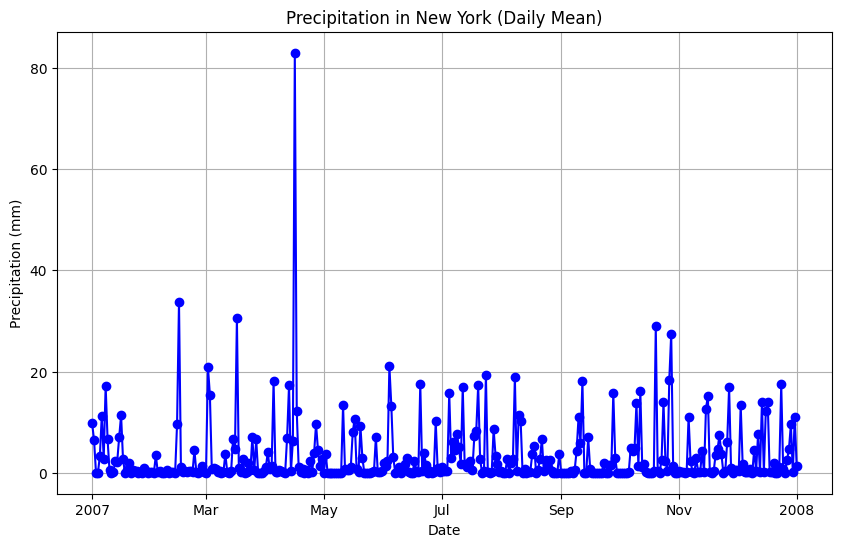

In [73]:
import matplotlib.pyplot as plt

lon_range = (360 - 74.25, 360 - 73.7)  # Converted to 285.75 - 286.3
lat_range = (40.5, 45.0)  # Latitude remains the same

ny_precip = ds.sel(latitude=slice(*lat_range), longitude=slice(*lon_range))
print(ny_precip)

if ny_precip.precip.count() > 0:
    print("Precipitation data exists for this range.")
else:
    print("No precipitation data for the specified range.")

# Compute the average precipitation over the region
ny_precip_mean = ny_precip.precip.mean(dim=["latitude", "longitude"])

# Plot the data
plt.figure(figsize=(10, 6))
ny_precip_mean.plot(marker='o', color='blue')
plt.title("Precipitation in New York (Daily Mean)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.show()